In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyfftw
from pyfftw.interfaces.numpy_fft import fftshift
from pyfftw.interfaces.numpy_fft import ifftshift
from pyfftw.interfaces.numpy_fft import rfftn
from pyfftw.interfaces.numpy_fft import irfftn
from pyfftw.interfaces.numpy_fft import rfft2
from pyfftw.interfaces.numpy_fft import irfft2
import scipy as sp
import seaborn as sns

from pyem import mrc
from pyem.util import *
from pyem.vop import *

%matplotlib inline
sns.set()
pyfftw.interfaces.cache.enable()

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [104]:
def radial_profile(data, center=(0,0), r=None):
    if r is None:
        y, x = np.indices((data.shape))
        r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [105]:
def radial_sum(data, center=(0,0), r=None):
    if r is None:
        y, x = np.indices((data.shape))
        r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        r = r.astype(np.int)c
#     radialsum = sp.stats.binned_statistic(r.ravel(), data.ravel(), "sum", 192)
    tbin = np.bincount(r.ravel(), data.ravel())
    return tbin

In [4]:
def fourier_ring_correlation(p1, p2):
    center = (0, p1.shape[0] // 2)
    fc = fftshift(p1 * np.conj(p2), axes=0)
    fcr = radial_sum(np.real(fc), center)
    fcc = radial_sum(np.imag(fc), center)
    mag = np.sqrt(radial_sum(np.abs(fftshift(p1, axes=0))**2, center) * 
                  radial_sum(np.abs(fftshift(p2, axes=0))**2, center))
    frc = (fcr + fcc*1j) / mag
    return frc

In [5]:
disc, hdr = mrc.read("cryosparc_exp000406_022.mrc", inc_header=True, compat="relion")

In [6]:
pfac = 2
vol = grid_correct(np.double(disc), pfac=pfac, order=1)
padvol = np.pad(vol, (vol.shape[0] * pfac - vol.shape[0]) // 2, "constant")
discft = rfftn(ifftshift(padvol), padvol.shape, threads=8)

/Users/student/Documents/IDEAProjects/pyem/pyem/vop/vop.py:71: RuntimeWarning: invalid value encountered in divide
  sinc = np.sin(np.pi * r) / (np.pi * r)  # Results in 1 NaN in the center.


In [7]:
discftc = np.zeros((387,387,194), dtype=np.complex128)
fill_ft(discft, discftc, 192)

In [25]:
a = np.arange(-45,225)
rots = [euler2rot(*np.deg2rad([15,90,i])) for i in a]
sz = [192, 96, 48]

In [10]:
p1 = interpolate_slice_numba(discftc, rots[45], size=sz[0])
p2 = interpolate_slice_numba(discftc, rots[45], size=sz[0])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


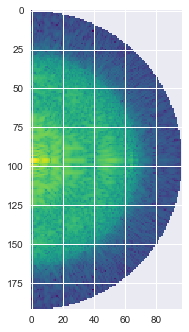

In [11]:
plt.imshow(fftshift(np.log(np.abs(np.sqrt(p1 * np.conj(p1)))), axes=0), cmap="viridis")

In [86]:
center = (0,96)
y, x = np.indices((p1.shape))
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
r = r.astype(np.int)
# rbin = (20* r/r.max()).astype(np.int)
r = fftshift(r, axes=0)

In [108]:
print np.sqrt(2 * 96**2)
print r.max()

135.7645019878171
135


In [14]:
r.shape

(192, 97)

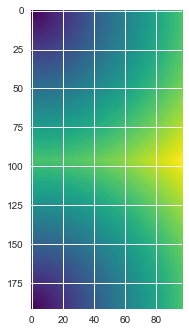

In [15]:
plt.imshow(r, cmap="viridis")

In [85]:
r[0:10,0:10]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 2,  2,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  3,  3,  4,  5,  5,  6,  7,  8,  9],
       [ 4,  4,  4,  5,  5,  6,  7,  8,  8,  9],
       [ 5,  5,  5,  5,  6,  7,  7,  8,  9, 10],
       [ 6,  6,  6,  6,  7,  7,  8,  9, 10, 10],
       [ 7,  7,  7,  7,  8,  8,  9,  9, 10, 11],
       [ 8,  8,  8,  8,  8,  9, 10, 10, 11, 12],
       [ 9,  9,  9,  9,  9, 10, 10, 11, 12, 12]])

In [91]:
# tbin = np.bincount(r.ravel(), data.ravel())
nr = np.bincount(r.ravel())
# radialprofile = tbin / nr

In [143]:
a = np.zeros(r.shape)
b = sp.randn(136)

In [144]:
a.flat = b[r.ravel()]

In [146]:
c = np.ones(a.shape)

In [147]:
c.flat *= b[r.ravel()]

In [150]:
b[:5]

array([ 0.71196088, -1.18786451,  0.61592483, -0.40776949, -1.31864353])

In [151]:
r[:5,:5]

array([[0, 1, 2, 3, 4],
       [1, 1, 2, 3, 4],
       [2, 2, 2, 3, 4],
       [3, 3, 3, 4, 5],
       [4, 4, 4, 5, 5]])

In [149]:
c[:5,:5]

array([[ 0.71196088, -1.18786451,  0.61592483, -0.40776949, -1.31864353],
       [-1.18786451, -1.18786451,  0.61592483, -0.40776949, -1.31864353],
       [ 0.61592483,  0.61592483,  0.61592483, -0.40776949, -1.31864353],
       [-0.40776949, -0.40776949, -0.40776949, -1.31864353, -0.66302508],
       [-1.31864353, -1.31864353, -1.31864353, -0.66302508, -0.66302508]])

In [154]:
np.array_equal(b[r], c)

True

In [107]:
fc = p1 * np.conj(p2)
fcr = radial_sum(np.real(fc), r=r)
fcc = radial_sum(np.imag(fc), r=r)
mag = np.sqrt(radial_sum(np.abs(p1)**2, r=r) * 
              radial_sum(np.abs(p2)**2, r=r))
frc = (fcr + fcc*1j) / mag

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


In [113]:
frc.shape

(136,)

In [114]:
ndex = index=np.arange(0, r.max() + 1)
fc_real = np.real(fc)

In [110]:
radial_mean = sp.ndimage.mean(fc_real, labels=r, index=ndex)
radial_mean.shape

(135,)

In [116]:
%timeit radial_profile(fc_real, r=r)

10000 loops, best of 3: 89.2 µs per loop


In [118]:
%timeit sp.ndimage.mean(fc_real, labels=r, index=ndex)

1000 loops, best of 3: 175 µs per loop


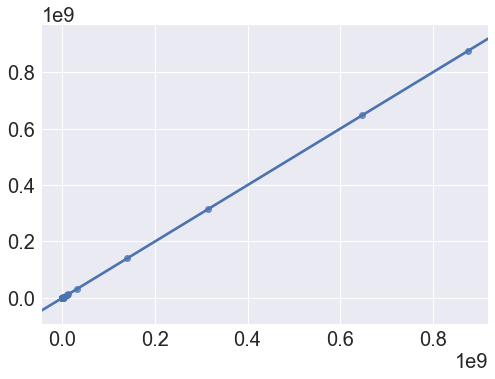

In [115]:
sns.regplot(radial_profile(fc_real, r=r), sp.ndimage.mean(fc_real, labels=r, index=ndex))

In [20]:
p1 = interpolate_slice_numba(discftc, rots[45], size=sz[0])
frc0 = fourier_ring_correlation(p1, p1)
N = 11
frc = np.zeros((N, frc0.size))
frc[0] = frc0
idx = [45, 46, 60, 75, 90, 135, 180, 195, 210, 226, 225]
for i in range(N):
    p2 = interpolate_slice_numba(discftc, rots[idx[i]], size=sz[0])
    frc[i] = fourier_ring_correlation(p1, p2)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


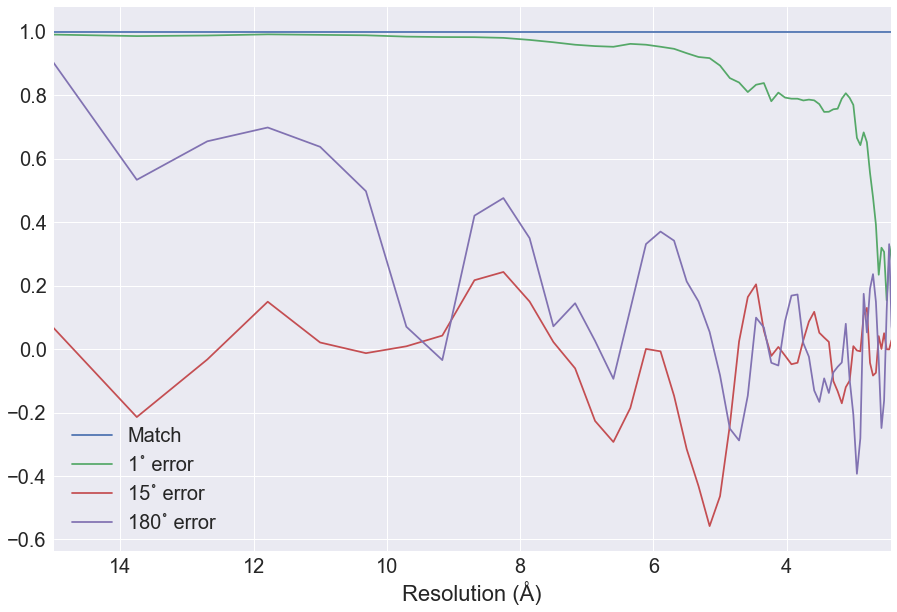

In [45]:
sns.set(font_scale=2)
f, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(1.2156/(radial_profile(r, (0,96)) / np.sqrt(2 * 96**2)),frc[[0,1,2,-1]].T)
ax.set_xlim((15,2.44))
ax.set_xlabel(u"Resolution (Å)")
ax.legend(["Match", u"1˚ error", u"15˚ error", u"180˚ error"])

In [171]:
frc_180 = fourier_ring_correlation(interpolate_slice_numba(discftc, rots[45], size=sz[0]),
                                  interpolate_slice_numba(discftc, rots[225], size=sz[0]))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


(15, 0)

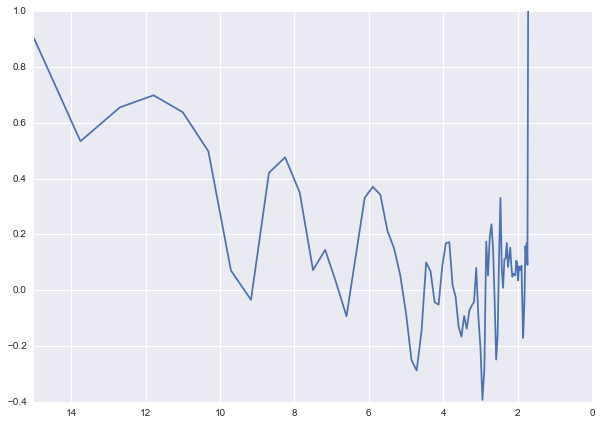

In [172]:
f, ax = plt.subplots(1, figsize=(10, 7))
ax.plot(1.2156/(radial_profile(r, (0,96)) / np.sqrt(2 * 96**2)), frc_180.T)
ax.set_xlim((15,0))